In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle

In [2]:
# Load data
datapath = "../data/daily_release"
data = pd.read_csv(f"{datapath}/results.csv")
data = data[data['story_item'] != 0]
data

,agent,timestep,story_item,adopted,prob,Narrative,Social,Trial
1,0,0,1,False,0.000000,0.000000,0.0,0
2,0,0,2,False,0.000000,0.000000,0.0,0
3,0,0,3,False,0.000000,0.000000,0.0,0
4,0,0,4,False,0.070926,0.141851,0.0,0
5,0,0,5,False,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...
52499995,49,999,16,True,1.000000,1.000000,1.0,49
52499996,49,999,17,True,1.000000,1.000000,1.0,49
52499997,49,999,18,False,0.000000,0.000000,0.0,49
52499998,49,999,19,True,1.000000,1.000000,1.0,49


In [3]:
with open(f"{datapath}/parameters.txt", 'r') as file:
    parameters = file.read()
    print(parameters)

alpha=0.5
beta=3.0
gamma=0.3
delta=1.0
I_scale=0.2
x_0=5.0
x_s=0.9
filestub=daily_release
seed=0
N=1000
R=[[1, 224], [2, 200], [3, 198], [4, 0], [5, 2], [6, 4], [7, 18], [8, 182], [9, 186], [10, 184], [11, 183], [12, 197], [13, 200], [14, 189], [15, 185], [16, 200], [17, 201], [18, 236], [19, 243], [20, 303]]



In [4]:
grouped_df = data.groupby(['Trial', 'timestep', 'story_item'])

# Calculating the percentage of agents who adopted each story item
percentage_df = grouped_df['adopted'].mean().reset_index()

percentage_df

,Trial,timestep,story_item,adopted
0,0,0,1,0.0
1,0,0,2,0.0
2,0,0,3,0.0
3,0,0,4,0.1
4,0,0,5,0.0
...,...,...,...,...
999995,49,999,16,1.0
999996,49,999,17,1.0
999997,49,999,18,0.0
999998,49,999,19,1.0


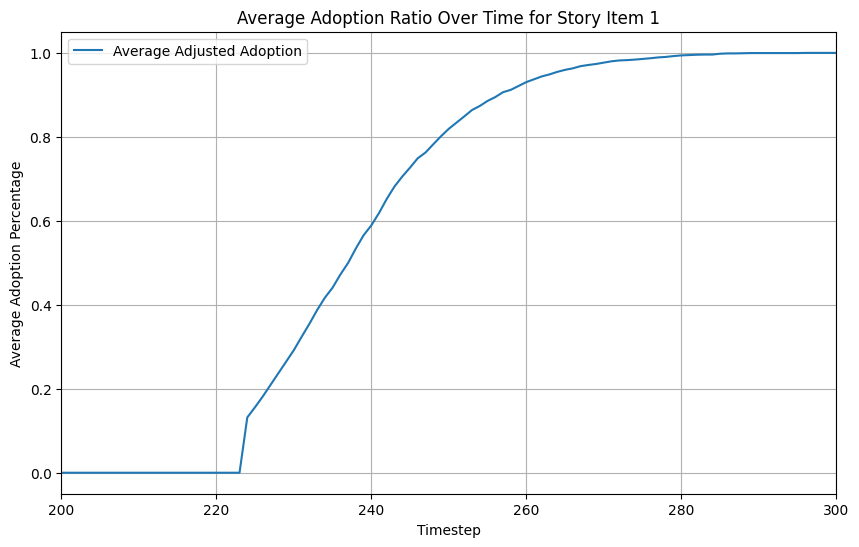

In [5]:
# Filtering the dataframe for story_item 1
story_item_0_df = percentage_df[percentage_df['story_item'] == 1]

# Finding the maximum timestep across all trials
max_timestep = story_item_0_df['timestep'].max()

# Creating a new DataFrame to store the adjusted data
adjusted_story_item_0_df = pd.DataFrame()

# Looping through each unique trial in story_item_0_df
for trial in story_item_0_df['Trial'].unique():
    trial_df = story_item_0_df[story_item_0_df['Trial'] == trial]

    # Check if the trial ends before the max timestep
    last_timestep = trial_df['timestep'].max()
    if last_timestep < max_timestep:
        # If it does, create additional rows for each missing timestep
        additional_rows = pd.DataFrame({
            'Trial': trial,
            'timestep': range(last_timestep + 1, max_timestep + 1),
            'story_item': 0,
            'adopted': 1  # Setting the adoption rate to 100%
        })
        # Append the additional rows to the trial's dataframe
        trial_df = pd.concat([trial_df, additional_rows], ignore_index=True)

    # Append the trial's dataframe to the adjusted dataframe
    adjusted_story_item_0_df = pd.concat([adjusted_story_item_0_df, trial_df], ignore_index=True)

# Grouping by timestep in the adjusted dataframe and calculating the mean adoption percentage
average_adjusted_adoption_df = adjusted_story_item_0_df.groupby('timestep')['adopted'].mean().reset_index()

# Plotting the adjusted graph
plt.figure(figsize=(10, 6))
plt.plot(average_adjusted_adoption_df['timestep'], average_adjusted_adoption_df['adopted'], label='Average Adjusted Adoption')

plt.xlabel('Timestep')
plt.ylabel('Average Adoption Percentage')
plt.title('Average Adoption Ratio Over Time for Story Item 1')
plt.legend()
plt.grid(True)
plt.xlim(200, 300)
plt.show()


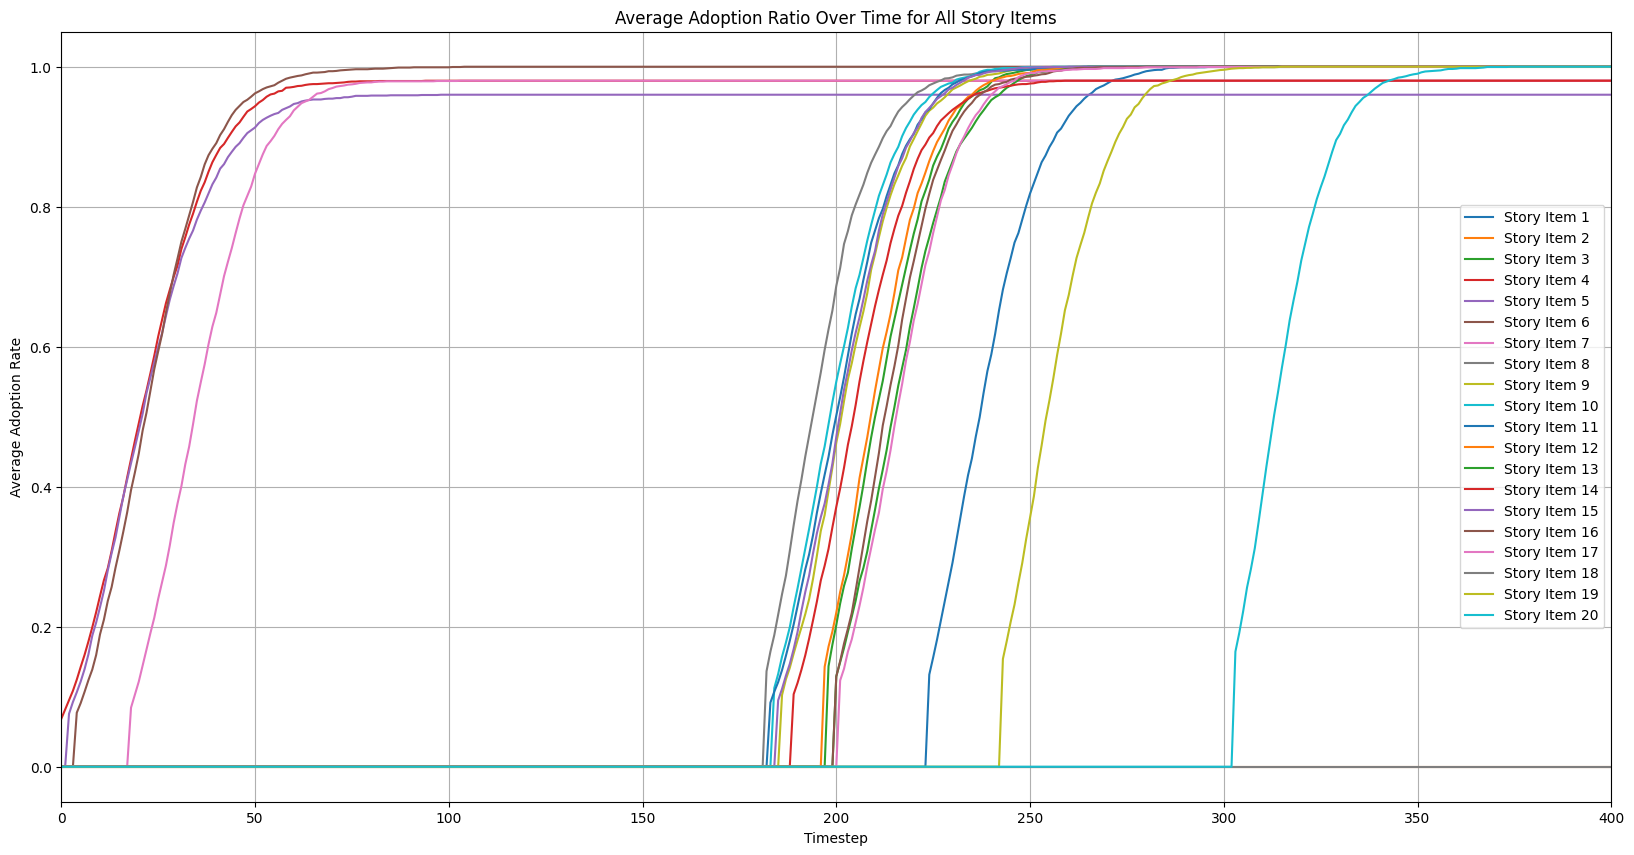

In [6]:
# Creating a new DataFrame to store the adjusted data for all story items
adjusted_percentage_df = pd.DataFrame()

# Finding the maximum timestep across all trials
max_timestep = percentage_df['timestep'].max()

# Looping through each unique trial and story item in the original dataframe
for trial in percentage_df['Trial'].unique():
    for story_item in percentage_df['story_item'].unique():
        trial_story_item_df = percentage_df[(percentage_df['Trial'] == trial) & (percentage_df['story_item'] == story_item)]

        # Check if the trial ends before the max timestep
        last_timestep = trial_story_item_df['timestep'].max()
        if last_timestep < max_timestep:
            # If it does, create additional rows for each missing timestep
            additional_rows = pd.DataFrame({
                'Trial': trial,
                'timestep': range(last_timestep + 1, max_timestep + 1),
                'story_item': story_item,
                'adopted': 1  # Setting the adoption rate to 100%
            })
            # Append the additional rows to the trial's dataframe
            trial_story_item_df = pd.concat([trial_story_item_df, additional_rows], ignore_index=True)

        # Append the trial's dataframe to the adjusted dataframe
        adjusted_percentage_df = pd.concat([adjusted_percentage_df, trial_story_item_df], ignore_index=True)

# Grouping by timestep and story item in the adjusted dataframe and calculating the mean adoption rate
average_adjusted_adoption_df = adjusted_percentage_df.groupby(['timestep', 'story_item'])['adopted'].mean().reset_index()

# Plotting the adjusted graph for all story items
plt.figure(figsize=(20, 10))
for story_item in average_adjusted_adoption_df['story_item'].unique():
    story_item_df = average_adjusted_adoption_df[average_adjusted_adoption_df['story_item'] == story_item]
    plt.plot(story_item_df['timestep'], story_item_df['adopted'], label=f'Story Item {story_item}')

plt.xlabel('Timestep')
plt.ylabel('Average Adoption Rate')
plt.title('Average Adoption Ratio Over Time for All Story Items')
plt.legend()
plt.grid(True)
plt.xlim(0, 400)
plt.show()


In [7]:
# Grouping the data by 'Trial', 'agent', and 'timestep'
grouped_data = data.groupby(['Trial', 'agent', 'timestep'])

# Function to check if all story items are adopted by an agent at a given timestep
def all_items_adopted(group):
    return group['adopted'].all()

# Applying the function to each group
adopted_all_items = grouped_data.apply(all_items_adopted)

# Resetting index to make 'Trial', 'agent', and 'timestep' columns again
adopted_all_items = adopted_all_items.reset_index(name='all_adopted')

# Grouping by 'Trial' and 'timestep' to count the number of agents who adopted all items
summary_data = adopted_all_items.groupby(['Trial', 'timestep']).all_adopted.sum().reset_index(name='whole_adopted')

# Calculate the total number of unique agents in the simulation
total_agents = data['agent'].nunique()

# Adding a new column 'whole_adoption_ratio' to the summary dataframe
summary_data['whole_adoption_ratio'] = summary_data['whole_adopted'] / total_agents

summary_data


,Trial,timestep,whole_adopted,whole_adoption_ratio
0,0,0,0,0.0
1,0,1,0,0.0
2,0,2,0,0.0
3,0,3,0,0.0
4,0,4,0,0.0
...,...,...,...,...
49995,49,995,0,0.0
49996,49,996,0,0.0
49997,49,997,0,0.0
49998,49,998,0,0.0


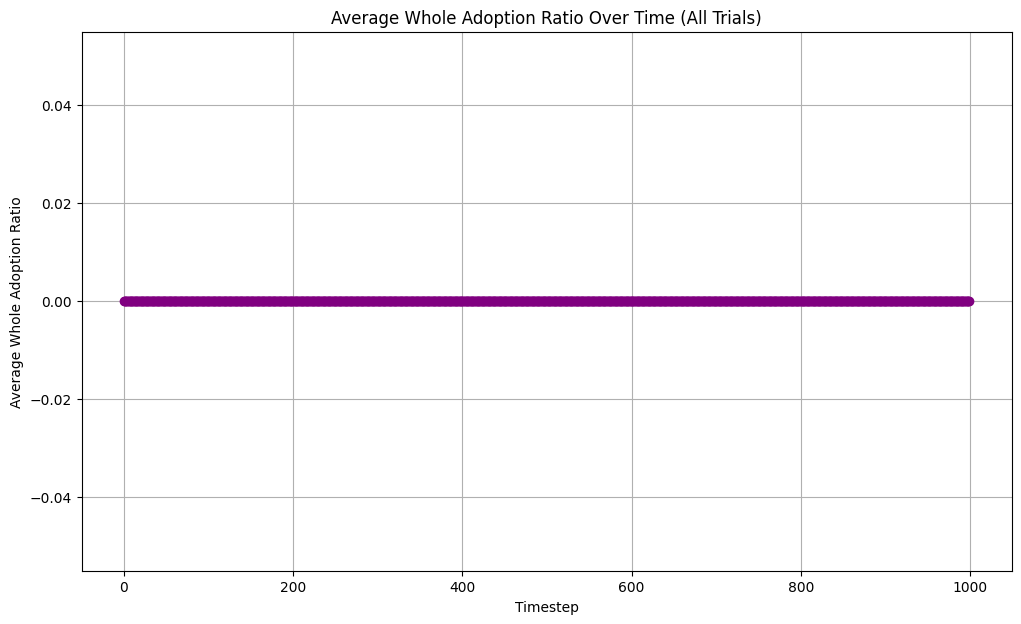

In [8]:
# Finding the maximum timestep across all trials
max_timestep = summary_data['timestep'].max()

# Creating a new DataFrame to store the adjusted data
adjusted_data = pd.DataFrame()

# Looping through each unique trial in the original dataframe
for trial in summary_data['Trial'].unique():
    trial_data = summary_data[summary_data['Trial'] == trial]

    # Check if the trial ends before the max timestep
    last_timestep = trial_data['timestep'].max()
    if last_timestep < max_timestep:
        # If it does, create additional rows for each missing timestep
        additional_rows = pd.DataFrame({
            'Trial': trial,
            'timestep': range(last_timestep + 1, max_timestep + 1),
            'whole_adopted': trial_data.iloc[-1]['whole_adopted'],  # Keep the last known whole_adopted value
            'whole_adoption_ratio': trial_data.iloc[-1]['whole_adoption_ratio']  # Keep the last known adoption ratio
        })
        # Append the additional rows to the trial's dataframe
        trial_data = pd.concat([trial_data, additional_rows], ignore_index=True)

    # Append the trial's dataframe to the adjusted dataframe
    adjusted_data = pd.concat([adjusted_data, trial_data], ignore_index=True)

# Grouping by timestep in the adjusted dataframe and calculating the mean whole adoption ratio
average_adjusted_adoption_data = adjusted_data.groupby('timestep').whole_adoption_ratio.mean().reset_index()

# Plotting the adjusted graph
plt.figure(figsize=(12, 7))
plt.plot(average_adjusted_adoption_data['timestep'], average_adjusted_adoption_data['whole_adoption_ratio'], marker='o', color='purple')
plt.title('Average Whole Adoption Ratio Over Time (All Trials)')
plt.xlabel('Timestep')
plt.ylabel('Average Whole Adoption Ratio')
plt.grid(True)
#plt.xlim(250, 350)
plt.show()

In [9]:
# Calculate the threshold of unique story items
threshold = int(data['story_item'].nunique() * 0.85)

# Function to check most story items are adopted by an agent at a given timestep
def most_items_adopted(group):
    return group['adopted'].sum() >= threshold

# Applying the function to each group
adopted_most_items = grouped_data.apply(most_items_adopted)

# Resetting index to make 'Trial', 'agent', and 'timestep' columns again
adopted_most_items = adopted_most_items.reset_index(name='mostly_adopted')

# Grouping by 'Trial' and 'timestep' to count the number of agents who adopted 90% of items
summary_data_2 = adopted_most_items.groupby(['Trial', 'timestep']).mostly_adopted.sum().reset_index(name='mostly_adopted')

# Calculate the total number of unique agents in the simulation
total_agents = data['agent'].nunique()

# Adding a new column 'ninety_adoption_ratio' to the summary dataframe
summary_data_2['most_adoption_ratio'] = summary_data_2['mostly_adopted'] / total_agents

summary_data_2

,Trial,timestep,mostly_adopted,most_adoption_ratio
0,0,0,0,0.0
1,0,1,0,0.0
2,0,2,0,0.0
3,0,3,0,0.0
4,0,4,0,0.0
...,...,...,...,...
49995,49,995,50,1.0
49996,49,996,50,1.0
49997,49,997,50,1.0
49998,49,998,50,1.0


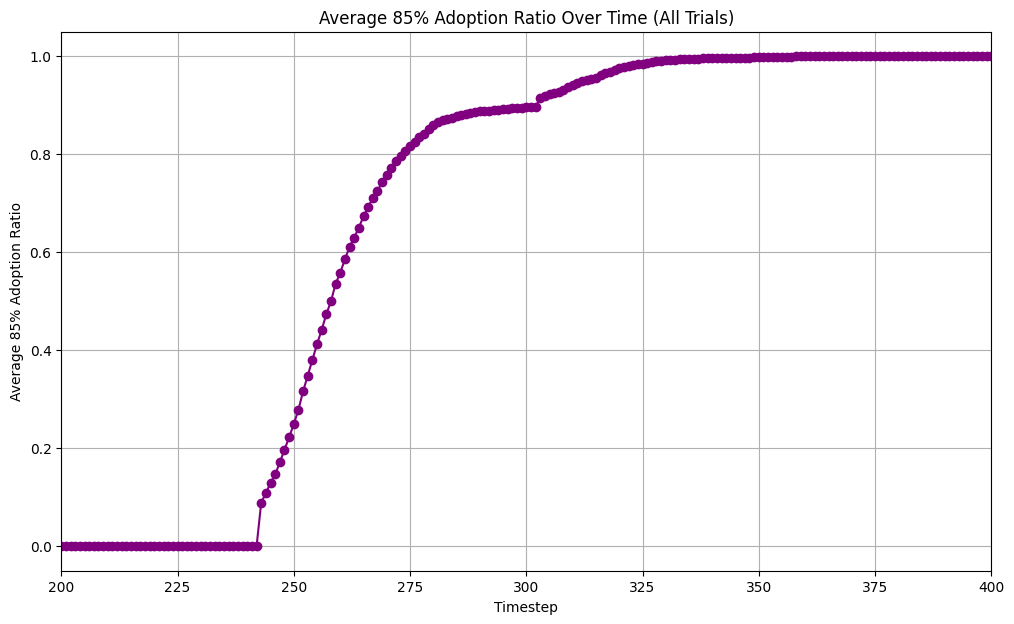

In [10]:
# Finding the maximum timestep across all trials
max_timestep = summary_data_2['timestep'].max()

# Creating a new DataFrame to store the adjusted data
adjusted_data_2 = pd.DataFrame()

# Looping through each unique trial in the original dataframe
for trial in summary_data_2['Trial'].unique():
    trial_data_2 = summary_data_2[summary_data_2['Trial'] == trial]

    # Check if the trial ends before the max timestep
    last_timestep = trial_data_2['timestep'].max()
    if last_timestep < max_timestep:
        # If it does, create additional rows for each missing timestep
        additional_rows = pd.DataFrame({
            'Trial': trial,
            'timestep': range(last_timestep + 1, max_timestep + 1),
            'mostly_adopted': trial_data_2.iloc[-1]['mostly_adopted'],
            'most_adoption_ratio': trial_data_2.iloc[-1]['most_adoption_ratio']
        })
        # Append the additional rows to the trial's dataframe
        trial_data_2 = pd.concat([trial_data_2, additional_rows], ignore_index=True)

    # Append the trial's dataframe to the adjusted dataframe
    adjusted_data_2 = pd.concat([adjusted_data_2, trial_data_2], ignore_index=True)

# Grouping by timestep in the adjusted dataframe and calculating the mean most adoption ratio
average_adjusted_adoption_data_2 = adjusted_data_2.groupby('timestep').most_adoption_ratio.mean().reset_index()

# Plotting the adjusted graph
plt.figure(figsize=(12, 7))
plt.plot(average_adjusted_adoption_data_2['timestep'], average_adjusted_adoption_data_2['most_adoption_ratio'], marker='o', color='purple')
plt.title('Average 85% Adoption Ratio Over Time (All Trials)')
plt.xlabel('Timestep')
plt.ylabel('Average 85% Adoption Ratio')
plt.grid(True)
plt.xlim(200, 400)
plt.show()